# Проект "Прогноз рынка видеоигр на 2017 год"

Производится анализ данных о продажах и рейтингах игр, выпущенных до 2016 года на различных игровых платформах. Цель исследования - определить стратегию выбора потенциально наиболее успешных продуктов на 2017 год. В исследовании будут выделены циклы развития рынка видеоигр и проведён подробный анализ текущего периода: определена целевая аудитория, игровая платформа и жанры, позволяющие получить максимальные показатели продаж.

## Предобработка данных

### Первичный анализ и преобразования

В исследовании участвует генеральная совокупность данных по 16715 релизам видеоигр. В базе данных указаны название, год релиза, жанр, возрастной рейтинг и платформа на которой выпущена игра, а также её показатели продаж в 3 макрорегионах(Северная Америка, Европа, Япония), пользовательские и профессиональные рейтинги.

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
# импортируем данные в датафрейм и выведем краткую информацию
try:
    data = pd.read_csv('C:\\practicum\\games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [65]:
data.head(10) # выведем первые 10 строк исходной выборки

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [66]:
data.columns = data.columns.str.lower()
#приводим названия колонок к нижнему регистру и проверяем результат
data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


### Гистограммы исходных данных

Построим гистограммы стартовых числовых параметров: год выпуска, уровни продаж, отзывы критиков. На гистрограммах продаж заметны существенные выбросы, которые нуждаются в дальнейшей корректировке

array([[<AxesSubplot:title={'center':'year_of_release'}>,
        <AxesSubplot:title={'center':'na_sales'}>],
       [<AxesSubplot:title={'center':'eu_sales'}>,
        <AxesSubplot:title={'center':'jp_sales'}>],
       [<AxesSubplot:title={'center':'other_sales'}>,
        <AxesSubplot:title={'center':'critic_score'}>]], dtype=object)

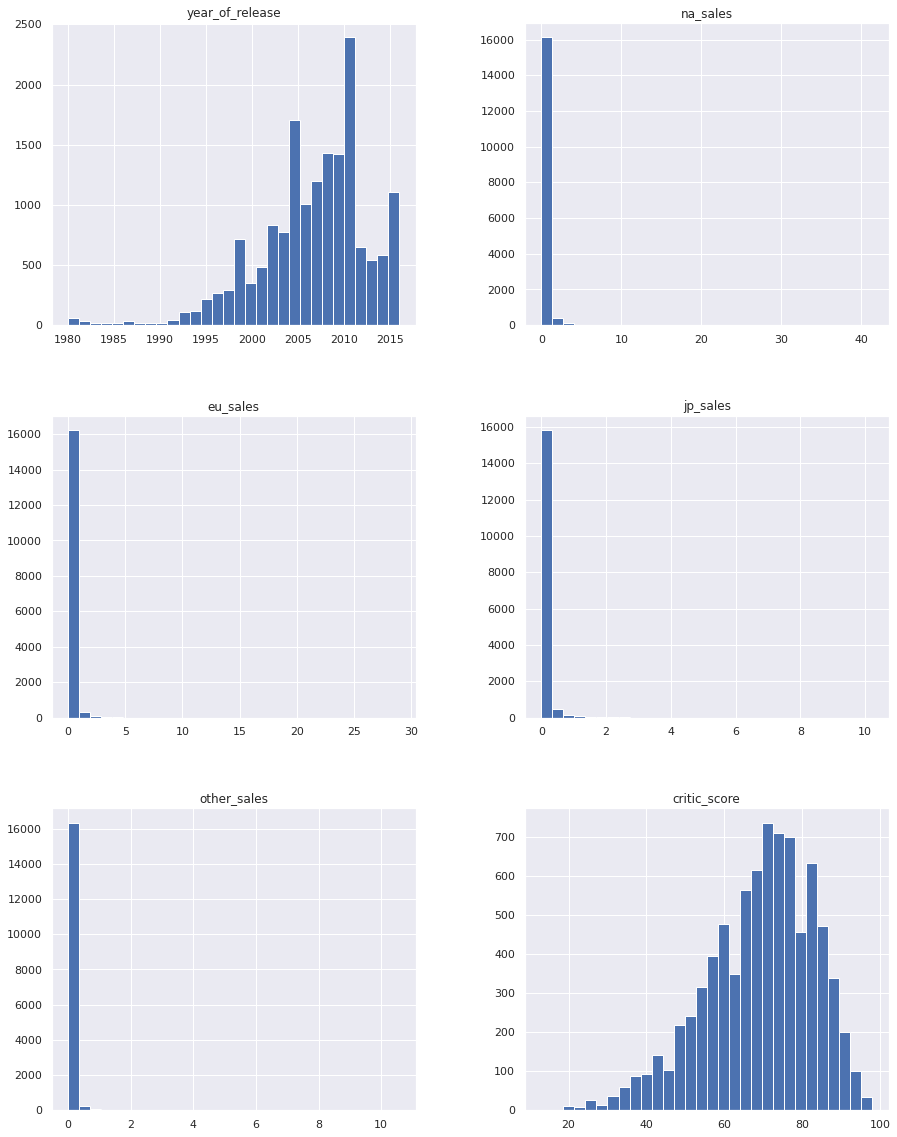

In [67]:
data.hist(figsize = (15, 20), bins = 30)             

### Столбец name

В столбце с названиями игр всего два пропуска - удалим эти строки. Переведём названия к нижнему регистру и сформируем отдельную таблицу со списком игр, которые имели более одного релиза(вероятно, на разных платформах). Это поможет в дальнейшем при заполнении пропусков по другим параметрам.

In [68]:
data = data.dropna(subset=['name']) # удаляем пропуски
data['name'] = data['name'].str.lower() # приводим названия к нижнему регистру
name = data['name'].value_counts().to_frame().reset_index()
name.rename(columns={'index': 'game', 'name': 'count'}, inplace=True)
duplicates = name.query('count>1') # создаем таблицу повторных релизов и формируем из неё список названий
duplicates_list = duplicates['game'].to_list()

### Столбец platform

Столбец с названиями платформ не содержит пропусков. Проверим список уникальных значений на наличие возможных некорректных параметров - они тоже отсутствуют.

In [69]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

### Столбец year_of_release

Столбец с годами выпуска имеет 269 пропусков, что составляет около 1.5% от изначального объёма данных. Так как год релиза является принципиально важной информацией для анализа, а размер потерянных данных невелик - удалим эти строки. Кроме этого, переведём формат к целым числам и построим гистрограмму, чтобы проконтролировать чистоту данных.

<AxesSubplot:>

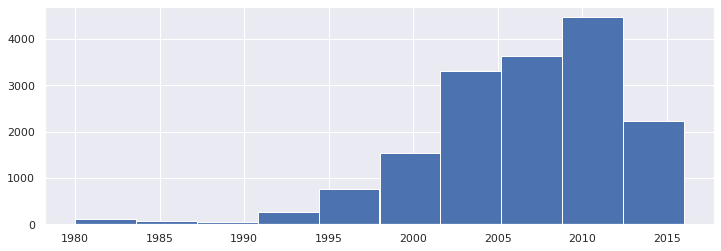

In [70]:
data = data.dropna(subset=['year_of_release']) # удаляем строки с пропусками в столбце год релиза
data['year_of_release'] = data['year_of_release'].astype('int') # переводим в формат int
data['year_of_release'].hist()

### Столбец genre

Столбец с названиями жанров не содержит пропусков. Проверим список уникальных значений на наличие возможных некорректных параметров - они  отсутствуют.

In [71]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

### Столбцы со значениями продаж
Как мы уже обращали внимание выше, столбцы с продажами содержат значительные выбросы. Выведем на экран строки с аномальными показателями по каждому региону. В каждой подгруппе содержится порядка 10-20 релизов, отличающихся от региона к региону. Среди них единичные мировые хиты - тетрис, Марио, The Sims или платформенные эксклюзивы, поставляемые в комплекте с покупкой игровой приставки. Чтобы эти значения не искажали средние показатели, оставим для дальнейшего анализа только те игры, которые дают не слишком выбивающиеся общие продажи.

In [72]:
data.query('na_sales>10')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,new super mario bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,wii play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,new super mario bros. wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,duck hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [73]:
data.query('eu_sales>6')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
6,new super mario bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,wii play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,new super mario bros. wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
10,nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
11,mario kart ds,DS,2005,Racing,9.71,7.47,4.13,1.90,91.0,8.6,E
12,pokemon gold/pokemon silver,GB,1999,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN


In [74]:
data.query('jp_sales>4')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,new super mario bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
8,new super mario bros. wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
11,mario kart ds,DS,2005,Racing,9.71,7.47,4.13,1.90,91.0,8.6,E
12,pokemon gold/pokemon silver,GB,1999,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN
19,brain age: train your brain in minutes a day,DS,2005,Misc,4.74,9.20,4.16,2.04,77.0,7.9,E
20,pokemon diamond/pokemon pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN
21,super mario land,GB,1989,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN


In [75]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']+data['other_sales'] 
# создаем столбец с суммарными продажами
data.sort_values(by = 'all_sales', ascending = False).head(10) #выведем топ-10 игр за всю историю

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,new super mario bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,wii play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,new super mario bros. wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,duck hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


Определим границу для отбора данных. Для этого выведем параметры общего количества продаж. Прибавив к среднему значению утроенное стандартное отклонение, получим верхнюю границу для отсечения - 5.2 млн копий.

In [76]:
data['all_sales'].describe()

count    16444.000000
mean         0.536023
std          1.558786
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: all_sales, dtype: float64

In [77]:
data = data.query('all_sales<5.2')

### Столбец critic_score

Рейтинговые параметры имеют огромную долю пропусков - их чуть менее половины от общего числа строк. Частично такая ситуация могла возникнуть у старых релизов, так как до масштабного развития рынка видеоигр рейтинги не систематизировались в едином источнике. 
Выбрасывать такое количество данных будет нерациональным. Пропуски заполним значением "заглушкой" 0. 

<AxesSubplot:>

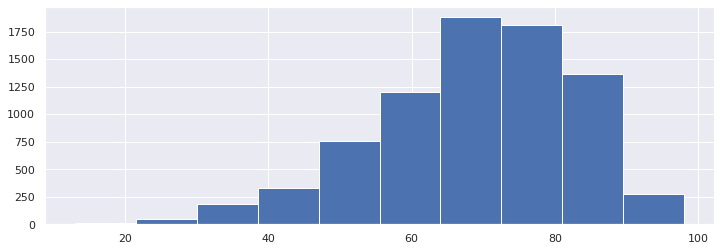

In [78]:
data['critic_score'].hist()

In [122]:
data['critic_score'] = data['critic_score'].fillna(0) #проставляем 0

### Столбец user_score

Аналогично оценкам критиков, пользовательские оценки получили распространённость только с появлением игровых цифровых маркетплейсов. Не все платформы собирают отзывы игроков в своих магазинах. Некоторые нишевые или старые игры могут иметь недостаточно оценок для выставления среднего. Всё это приводит к многочисленным пропускам в этом столбце. Новые релизы ещё могли не успеть собрать оценок пользователей, тогда возникает значение tbd='to be discussed'. Из-за наличия строкового значения, весь столбец получил формат object. Заменим tbd  и пропуски на 0 и переведём столбец в числовой формат.

In [80]:
data['user_score'].unique() #проверим уникальные значения, среди чисел есть одна строка

array(['8.6', nan, '6.1', '4', '7.6', '8.5', '6.5', '7.5', '8', '9',
       '9.2', '8.2', '7.1', '8.1', '7.3', '8.7', '5.4', '7.7', '8.9',
       '8.4', '7.9', '6.4', '3.4', '9.1', '8.3', '4.8', '4.9', '4.5',
       '9.3', '6.2', '4.2', '7.8', '7.2', '6', '6.3', 'tbd', '8.8', '6.7',
       '7.4', '3.7', '7', '6.9', '6.8', '4.1', '5.8', '5.6', '5.5', '4.4',
       '4.6', '5.9', '3.9', '6.6', '4.3', '5.3', '3.2', '5.7', '3.1',
       '2.9', '9.4', '5.2', '5', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9',
       '3', '2.7', '2.2', '2', '9.5', '2.6', '2.1', '3.6', '2.8', '1.8',
       '3.8', '0', '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7',
       '1.2', '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

<AxesSubplot:>

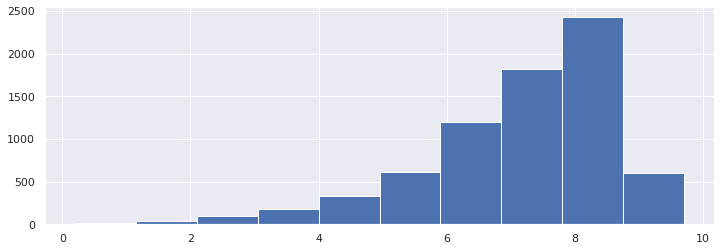

In [81]:
data['user_score'] = data['user_score'].replace('tbd', '0') #заменяем неопределенный рейтинг на 0
data['user_score'] = data['user_score'].astype('float') #переводим в числовой формат
data['user_score'] = data['user_score'].fillna(0) # остальные пропуски заменяем на 0
data.loc[data['user_score']!=0, 'user_score'].hist() # итоговая гистограмма без 0

### Столбец rating

Рейтинг видеоигр используется для определения допустимости контента для разных возрастных групп. В базе данных представлен Entertainment Software Rating Board (ESRB) - это северо-американская классификация. Игры, ориентированные только на азиатские рынки могут её не иметь. Кроме этого, есть альтернативные системы, такие как PEGI, в случае, если игра была классифицирована по ней, аналог в ESRB мог не указываться. Всё это приводит к большому количеству невосстанавливаемых пропусков. Заменим в дубликатах на моду, а во все остальные проставим unknown. Также создадим дополнительный столбец, где для удобства анализа переведём буквенную кодировку в значения возраста.

In [82]:
data['rating'].unique() #уникальные значения соответствуют ESRB

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [83]:
for game in duplicates_list: #замена пропусков в дубликатах на моду
    data['rating'] = data['rating'].fillna(data.loc[data['name'] == game, 'rating'].mode()) 
data['rating'] = data['rating'].fillna('unknown') #остальные пропуски заменяем заглушкой

In [84]:
def rating_age(rating): #функция для перевода буквенной классификации в возрастную
    if rating == 'E':
        return '0+'
    elif rating == 'K-A':
        return '0+'
    elif rating == 'EC':
        return '3+'
    elif rating == 'E10+':
        return '10+'
    elif rating == 'T':
        return '13+'
    elif rating == 'M':
        return '17+'
    elif rating == 'AO':
        return '18+'
    elif rating == 'RP':
        return 'NoCat'
    elif rating == 'unknown':
        return 'NoCat'

In [85]:
data['rating_age'] = data['rating'].apply(rating_age) #создаём дополнительный столбец с возрастами

In [86]:
data.drop_duplicates() #удаляем полные дубликаты 
data.isna().sum() #проверяем заполненность всех пропусков

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
all_sales          0
rating_age         0
dtype: int64

## Исследовательский анализ данных

Главная цель исследования - сделать прогноз на 2017 год. Данные изначальной выборки для этого явно излишни. Нам предстоит выделить циклы развития рынка видеоигр, чтобы оставить для анализа данные только текущего периода.

### Количество выпущенных игр по годам

Выведем общую статистику продаж игр по годам с 1980 по 2016. Можно выделить следующие периоды: зачатки индустрии с 1980 по 1993, бурное развитие технологий с 1994 по 2001. Выход на массовый рынок и бум выпуска видеоигр в 2002-2010. С 2010 происходит постепенное усложнение процесса разработки, которое делает его более долгим и менее доступным для инди-разработчиков. С 2013 года количество выпущенных игр становится на поток и выходит на плато. 

<AxesSubplot:xlabel='год выпуска', ylabel='количество'>

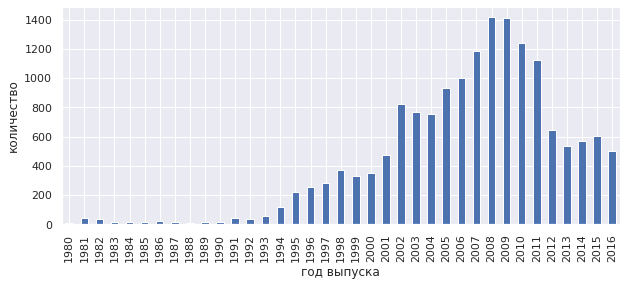

In [87]:
data.groupby('year_of_release')['year_of_release'].count().plot(kind = 'bar', figsize = (10, 4), xlabel = 'год выпуска', ylabel = 'количество')

### Продажи на разных платформах

Так как технические требования к играм постоянно меняются, срок жизни игровой платформы составляет всего несколько лет, и выпускать продукты для устаревших платформ не имеет смысла. Выясним, какие 15 игровых платформ были наиболее популярны за весь период исследования и построим хитмеп с распределением продаж по годам, чтобы выделить наиболее перспективные модели.


<AxesSubplot:title={'center':'топ-15 игровых платформ'}, xlabel='игровая платформа', ylabel='количество проданных игр'>

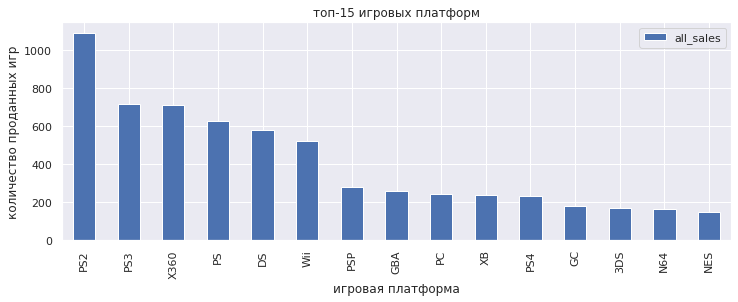

In [88]:
#Построим столбчатую диаграмму общих продаж по разным платформам и выведем топ-15
max_sales = data.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum').sort_values(by = 'all_sales', ascending = False).head(15)
max_sales.plot(kind = 'bar', xlabel = 'игровая платформа', ylabel = 'количество проданных игр', title = 'топ-15 игровых платформ')

Text(0.5, 1.0, 'Распределение продаж на разных платформах по годам')

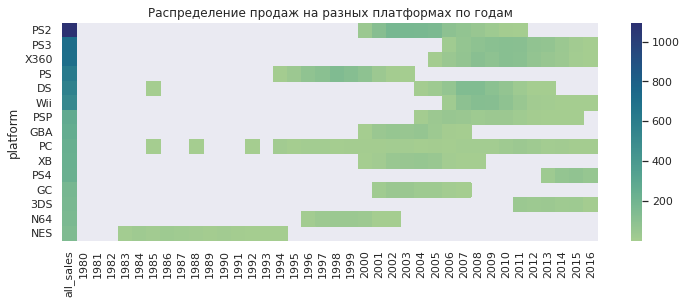

In [89]:
# сформируем сводную таблицу продаж по годам и платформам
year_sales = data.pivot_table(index = 'platform', columns = 'year_of_release', values = 'all_sales', aggfunc = 'sum')
year_max_sales = max_sales.join(year_sales, how = 'inner') #объединим её с таблицей топ-15 платформ
sns.heatmap(year_max_sales, cmap="crest")#строим хитмеп распределения продаж по годам
plt.title('Распределение продаж на разных платформах по годам')

In [90]:
data_new = data.query('year_of_release>2013').reset_index(drop = True) 
# создаём новый датасет для анализа с датами начиная с 2014 

In [91]:
#сводная таблица продаж по годам
sales_new = data_new.pivot_table(index = 'platform', columns = 'year_of_release', values = 'all_sales', aggfunc = 'sum')
sales_new['total_sales'] = sales_new[2014]+sales_new[2015]+sales_new[2016] #столбец с суммой продаж за 3 года
sales_new

year_of_release,2014,2015,2016,total_sales
platform,,,,
3DS,24.53,27.78,8.00,60.31
PC,13.28,8.52,5.25,27.05
PS3,42.49,16.82,3.60,62.91
PS4,68.00,80.54,56.26,204.80
PSP,0.24,0.12,NaN,NaN
PSV,11.90,6.25,4.25,22.40
Wii,3.75,1.14,0.18,5.07
WiiU,14.94,16.35,4.60,35.89
X360,34.74,11.96,1.52,48.22


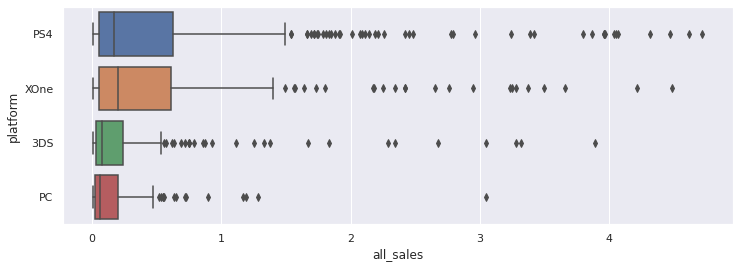

In [92]:
# датасет только по 4 актуальным платформам
data_actual = data_new.loc[(data_new['platform'] == '3DS') | (data_new['platform'] == 'PS4') | (data_new['platform'] == 'XOne') | (data_new['platform'] == 'PC')]
sns.set(rc = {"figure.figsize":(12, 4)})
box = sns.boxplot(data = data_actual, x='all_sales', y = 'platform') #ящики со статистикой продаж

**Вывод** Временные циклы в развитии рынка игровых платформ примерно соответствуют предыдущим выводам по уровню продаж. Становится понятным, что для анализа стоит выбрать промежуток с 2014 по 2016 год. Большинство старых платформ уже не поддерживается новыми релизами, а все новые поколения укрепились на рынке в этот период. Бум портативных и малоизвестных на мировом рынке азиатских платформ к 2014 уже завершился и остались только три крупных производителя - Sony(PS4), Microsoft(Xbox One), Nintengo(3DS). Кроме этого, ПК остаётся хотя и не лидирующей, но стабильно используемой платформой для видеоигр. Игровые приставки в разы превосходят продажи игр на ПК, но при этом имеют небольшой срок жизни не более 5-10 лет, в то время как ПК показывает стабильный уровень из года в год. Компактные платформы почти полностью уступили рынок стационарным. Единственная оставшаяся мобильная платформа 3DS к 2016 году потеряла в объёмах продаж, но всё ещё занимает ощутимую долю рынка, поэтому в 2017 её ещё не стоит исключать из списка лидеров. 


  ### Анализ влияния рейтингов на уровень продаж
  
  Проанализируем, стоит ли опираться на оценки игроков и критиков при выборе наиболее прибыльных направлений. Заметим, что при обработке данных в столбцах были проставлены 0 в качестве заглушек, поэтому, чтобы не искажать статистику, исключим такие строки из анализа. Для более точного исследования проведём его сначала только внутри одной платформы, наиболее популярной PS4. Вычислим корреляцию и построим диаграммы рассеивания

In [93]:
data_PS = data_new.query('platform == "PS4" and critic_score>0 and user_score>0').reset_index(drop = True)
data_PS.shape

(226, 13)

In [94]:
data_PS.corr()['all_sales'] # корреляция общего уровня продаж с другими параметрами

year_of_release   -0.207710
na_sales           0.919769
eu_sales           0.931685
jp_sales           0.554828
other_sales        0.996519
critic_score       0.393945
user_score         0.020501
all_sales          1.000000
Name: all_sales, dtype: float64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'зависимость продаж от оценки критиков PS4'}, xlabel='продажи', ylabel='оценка критиков'>

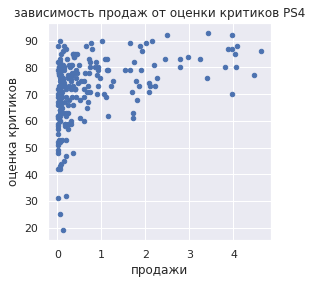

In [95]:
#диаграмма рассеивания зависимости продаж от оценки критиков
data_PS.plot(x ='all_sales', y ='critic_score', kind='scatter', figsize = (4,4), ylabel = 'оценка критиков', xlabel = 'продажи', title = 'зависимость продаж от оценки критиков PS4')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'зависимость продаж от оценки пользователей'}, xlabel='продажи', ylabel='оценка игроков'>

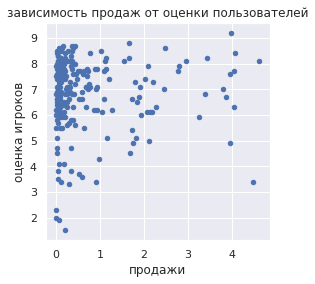

In [96]:
#диаграмма рассеивания зависимости продаж от оценки пользователей
data_PS.plot(x ='all_sales', y ='user_score', kind='scatter', figsize = (4,4), ylabel = 'оценка игроков', xlabel = 'продажи', title = 'зависимость продаж от оценки пользователей')

Корреляция между продажами и оценкой критиков невысокая, но всё же есть - около 0,4. На графике видно, что бестселлерами становятся только высоко оцененные критиками игры. Для оценки игроков корреляция почти 0 - игра очень низкой оценкой может выходить в топ продаж. В этом случае, как правило, ожидания игроков становятся завышенными и они начинают критичнее относится к любым недостаткам.
Изучим аномальные случаи - найдём самую продаваемую игру с низкой оценкой игроков и самую высокооценённую критиками игру, провалившую продажи.

In [97]:
data_PS.query('all_sales>1 and user_score<5') # игры с высокими продажами и низким рейтингом

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
1,call of duty: infinite warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47,17+
6,assassin's creed: unity,PS4,2014,Action,1.19,2.07,0.08,0.62,70.0,4.9,M,3.96,17+
32,madden nfl 17,PS4,2016,Sports,1.25,0.17,0.00,0.32,82.0,4.9,E,1.74,0+
35,no man's sky,PS4,2016,Action,0.63,0.76,0.03,0.27,71.0,4.5,T,1.69,13+


In [98]:
data_PS.query('all_sales<0.1 and critic_score>80') # игры с низкими продажами и высоким рейтингом

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
159,blazblue central fiction,PS4,2016,Fighting,0.04,0.00,0.03,0.01,85.0,7.6,T,0.08,13+
162,shovel knight,PS4,2015,Platform,0.03,0.03,0.00,0.01,90.0,7.6,E,0.07,0+
173,terraria,PS4,2014,Action,0.00,0.05,0.01,0.01,83.0,7.9,T,0.07,13+
184,steins;gate 0,PS4,2015,Adventure,0.00,0.00,0.05,0.00,81.0,8.3,M,0.05,17+
188,child of light,PS4,2014,Role-Playing,0.00,0.01,0.04,0.00,82.0,8.0,E10+,0.05,10+
205,the talos principle,PS4,2015,Puzzle,0.00,0.02,0.00,0.00,88.0,8.4,E10+,0.02,10+
206,dead rising 2,PS4,2016,Action,0.01,0.00,0.01,0.00,82.0,6.6,M,0.02,17+


In [99]:
data_new.query('name == "call of duty: infinite warfare"') #самая продаваемая игра с плохим рейтингом

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
4,call of duty: infinite warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.4,M,4.47,17+
46,call of duty: infinite warfare,XOne,2016,Shooter,1.46,0.74,0.00,0.22,78.0,3.1,M,2.42,17+
700,call of duty: infinite warfare,PC,2016,Shooter,0.04,0.08,0.00,0.01,73.0,3.0,M,0.13,17+


In [100]:
data_new.query('name == "shovel knight"') # игра с самым высоким рейтингом и очень низкими продажами

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
683,shovel knight,3DS,2015,Platform,0.08,0.04,0.02,0.01,90.0,8.2,E,0.15,0+
824,shovel knight,WiiU,2015,Platform,0.05,0.04,0.00,0.01,88.0,8.3,E,0.10,0+
892,shovel knight,PS4,2015,Platform,0.03,0.03,0.00,0.01,90.0,7.6,E,0.07,0+


In [101]:
data_Xone = data_new.query('platform == "XOne" and critic_score>0 and user_score>0').reset_index(drop = True)
data_Xone.corr()['all_sales']

year_of_release   -0.223474
na_sales           0.944750
eu_sales           0.826405
jp_sales           0.473960
other_sales        0.991016
critic_score       0.410363
user_score        -0.110096
all_sales          1.000000
Name: all_sales, dtype: float64

In [102]:
data_3DS = data_new.query('platform == "3DS" and critic_score>0 and user_score>0').reset_index(drop = True)
data_3DS.corr()['all_sales']

year_of_release   -0.186145
na_sales           0.854967
eu_sales           0.886130
jp_sales           0.914767
other_sales        0.902070
critic_score       0.284686
user_score         0.279850
all_sales          1.000000
Name: all_sales, dtype: float64

Построим диаграммы рассеивания для влияния оценки критиков на Xbox One и 3DS

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'зависимость продаж от оценки критиков 3DS'}, xlabel='продажи', ylabel='оценка критиков'>

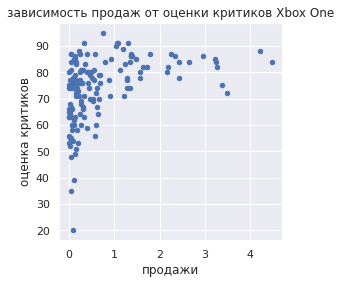

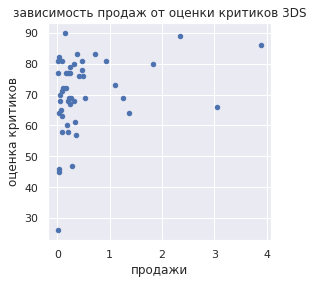

In [103]:
#диаграмма рассеивания зависимости продаж от оценки критиков
data_Xone.plot(x ='all_sales', y ='critic_score', kind='scatter', figsize = (4,4), ylabel = 'оценка критиков', xlabel = 'продажи', title = 'зависимость продаж от оценки критиков Xbox One')
#диаграмма рассеивания зависимости продаж от оценки критиков
data_3DS.plot(x ='all_sales', y ='critic_score', kind='scatter', figsize = (4,4), ylabel = 'оценка критиков', xlabel = 'продажи', title = 'зависимость продаж от оценки критиков 3DS')

Построим диаграммы рассеивания для влияния оценки пользователей на Xbox One и 3DS

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'зависимость продаж от оценки пользователей 3DS'}, xlabel='продажи', ylabel='оценка игроков'>

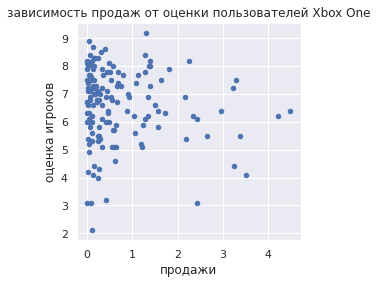

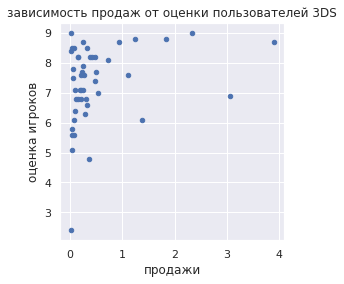

In [104]:
#диаграмма рассеивания зависимости продаж от оценки пользователей
data_Xone.plot(x ='all_sales', y ='user_score', kind='scatter', figsize = (4,4), ylabel = 'оценка игроков', xlabel = 'продажи', title = 'зависимость продаж от оценки пользователей Xbox One')
#диаграмма рассеивания зависимости продаж от оценки пользователей
data_3DS.plot(x ='all_sales', y ='user_score', kind='scatter', figsize = (4,4), ylabel = 'оценка игроков', xlabel = 'продажи', title = 'зависимость продаж от оценки пользователей 3DS')

Оценки критиков являются необходимым условием для хороших продаж - успешными становятся только высокооценённые игры. Посмотрим, как распределяются медианные оценки критиков и пользователей по жанрам на разных плафтормах.

In [105]:
data_actual.pivot_table(index = 'genre', columns = 'platform', values = 'critic_score', aggfunc = 'median').round(1)
#сводная таблица медианных рейтингов критиков разных жанров на разных платформах

platform,3DS,PC,PS4,XOne
genre,,,,
Action,0.0,72.0,59.0,60.0
Adventure,0.0,32.5,31.0,0.0
Fighting,0.0,75.0,66.0,67.0
Misc,0.0,0.0,0.0,66.0
Platform,70.5,74.0,79.0,75.0
Puzzle,0.0,NaN,88.0,NaN
Racing,NaN,71.0,69.0,64.0
Role-Playing,0.0,83.5,0.0,74.0
Shooter,NaN,78.0,73.0,78.0


**Выводы** Коэффициент корреляции на PS4 и Xbox one между продажами и рейтингом пользователей крайне близок к нулю, поэтому нельзя говорить об однозначной зависимости между этими параметрами. Однако при построении диаграмм рассеивания становится понятно, что шанс на высокие продажи среди игр заслуживших положительные оценки всё же выше. В то время как хорошие продажи для низко оценённых игр это аномалия. Большинство игр не выходят за рамки полумиллиона, но в верхней части обеих диаграмм облако более плотное.
Корреляция с оценками критиков не сильная, но присутствует - в районе 0,4 на PS4 и Xbox One. Хорошие продажи получают только высоко оценённые критиками игры. 
Приведены данные по двум самым аномальным играм. call of duty: infinite warfare имеет низкие оценки и высокие продажи(даже при учете, что данные за 2016 год неполные), а shovel knight с максимально положительными оценками остаётся нишевой малопопулярной игрой на всех платформах, где она выходила.
При этом в целом пользовательские рейтинги в среднем по жанру имеют существенные различия на разных платформах. Стоит обратить внимание, что пользователи ПК более критично относятся к играм, а пользователи 3DS - лояльно. Даже корреляция на этой платформе имеет отличия - для критиков и пользователей она примерно совпадает и равна 0.28. 

### Распределение продаж по жанрам

Проанализируем, какие жанры имеют большие шансы на аномальный успех, а какие показывают самые стабильные продажи. Для этого построим ящики по продажам на 4 популярных платформах по всем представленным в 2014-2016 годах на рынке жанрам. Также проверим распределение успешных жанров внутри платформ.

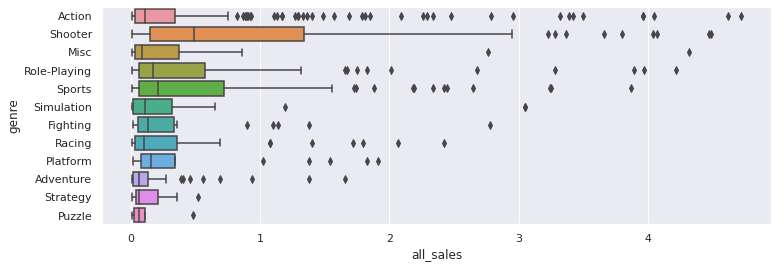

In [107]:
sns.set(rc = {"figure.figsize":(12, 4)})
box = sns.boxplot(data = data_actual, x='all_sales', y = 'genre') #ящики продаж по актуальным платформам за 2014-2016 гг

In [108]:
data_actual.groupby('genre')['name'].count() # количество выпущенных игр каждого жанра

genre
Action          347
Adventure        71
Fighting         28
Misc             59
Platform         22
Puzzle            8
Racing           49
Role-Playing    121
Shooter          88
Simulation       37
Sports           89
Strategy         32
Name: name, dtype: int64

array([<AxesSubplot:title={'center':'3DS'}, xlabel='genre'>,
       <AxesSubplot:title={'center':'PC'}, xlabel='genre'>,
       <AxesSubplot:title={'center':'PS4'}, xlabel='genre'>,
       <AxesSubplot:title={'center':'Xone'}, xlabel='genre'>],
      dtype=object)

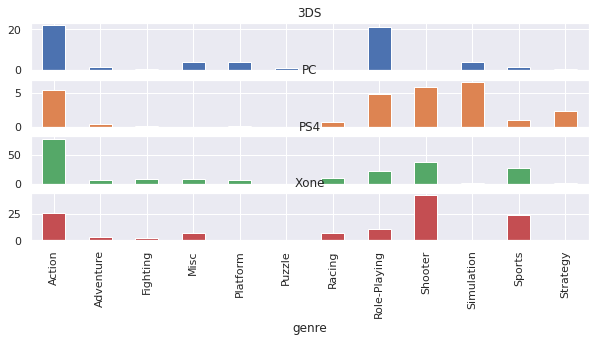

In [109]:
genre_sales = data_actual.pivot_table(index = 'genre', columns = 'platform', values = 'all_sales', aggfunc = 'sum')
genre_sales.plot(kind = 'bar', subplots=True, figsize=(10, 4), legend = False, title = ['3DS', 'PC', 'PS4', 'Xone'])
#столбчатые диаграммы распределения продаж по жанрам внутри платформ

**Выводы** 
- Шутеры(Shooter) лидируют с большим отрывом от всех жанров, почти не имея совсем провальных релизов. При этом среди пользователей ПК и Xbox One они занимают лидирующую позицию, но крайне плохо продаются на портативной 3DS. 
- Спортивные симуляторы(Sports) имеют хорошие шансы на успех, но только среди пользователей стационарных приставок PS4 и Xbox One. 
- Жанр Action стабильно популярен среди пользователей всех платформ, причём имеет наибольшее количество сверхпопулярных игр
- Сим игры(Simulation) и стратегии успешны только при выпуске на ПК
- РПГ(Role-Playing) показывают стабильно хорошие продажи, для пользователей 3DS это наиболее предпочтительный жанр
- Fighting потенциально успешен только среди пользователей PS4, имеет средний, но стабильный результат
- традиционные инди-жанры: Adventure, платформеры(Platform), головоломки(Puzzle) как правило рассчитаны на небольшой круг игроков и имеют ограниченные продажи. 
- Гонки(racing) это жанр с несколькими крупными тайтлами, занимающими подавляющую долю рынка, все остальные имеют довольно скромные показатели.

## Типичные пользователи регионов

Для различных регионов характерны разные предпочтения в жанрах и игровых платформах. Для каждого региона построим рейтинг топ-5 игровых платформ и жанров, а также самые востребованные возрастные категории игр. Стоит обратить внимание, что возрастная категория игры не может в точности указывать на возраст игрока.

### Северная Америка

In [110]:
data_NA = data_new.sort_values(by = 'na_sales', ascending = False) # датасет отсортирован по успешности в Северной Америке
data_NA.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
3,halo 5: guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49,13+
8,call of duty: advanced warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,0.0,4.9,M,4.28,17+
27,gears of war: ultimate edition,XOne,2015,Shooter,2.61,0.33,0.00,0.34,82.0,7.5,M,3.28,17+
0,super smash bros. for wii u and 3ds,WiiU,2014,Fighting,2.60,1.08,0.81,0.38,0.0,0.0,unknown,4.87,NoCat
10,fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22,17+


<AxesSubplot:title={'center':'топ-5 Платформ Северной Америки'}, ylabel='platform'>

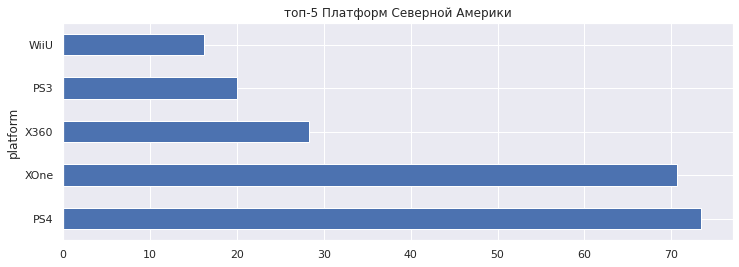

In [111]:
NA_top_platform = data_new.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head()
NA_top_platform.plot(kind = 'barh', title = 'топ-5 Платформ Северной Америки')

<AxesSubplot:title={'center':'топ-5 жанров Северной Америки'}, ylabel='genre'>

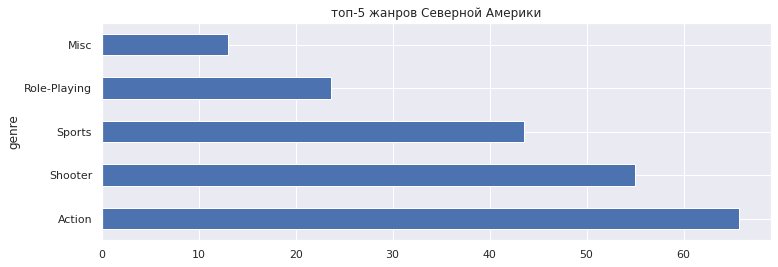

In [112]:
NA_top_genre = data_new.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head()
NA_top_genre.plot(kind = 'barh', title = 'топ-5 жанров Северной Америки')

### Европа

In [113]:
data_EU = data_new.sort_values(by = 'eu_sales', ascending = False) # датасет отсортирован по успешности в Европе
data_EU.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
9,fifa 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,0.0,4.5,E,4.28,0+
13,far cry 4,PS4,2014,Shooter,1.13,2.18,0.10,0.63,85.0,7.7,M,4.04,17+
11,battlefield 1,PS4,2016,Shooter,1.10,2.15,0.21,0.61,88.0,8.4,M,4.07,17+
14,the witcher 3: wild hunt,PS4,2015,Role-Playing,1.02,2.13,0.23,0.59,92.0,9.2,M,3.97,17+
28,fifa 16,XOne,2015,Sports,0.89,2.12,0.00,0.24,84.0,4.4,E,3.25,0+


<AxesSubplot:title={'center':'топ-5 Платформ Европы'}, ylabel='platform'>

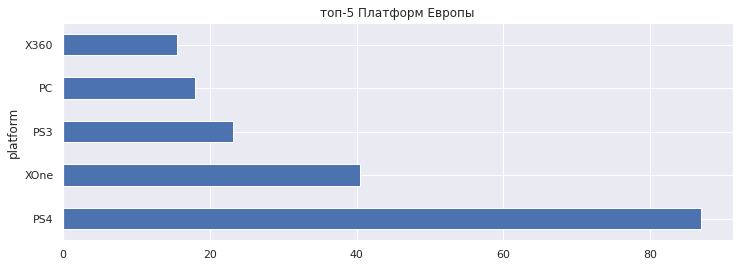

In [114]:
EU_top_platform = data_new.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head()
EU_top_platform.plot(kind = 'barh', title = 'топ-5 Платформ Европы')

<AxesSubplot:title={'center':'топ-5 жанров Европы'}, ylabel='genre'>

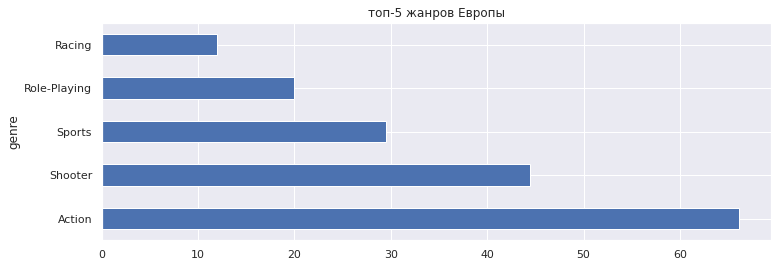

In [115]:
EU_top_genre = data_new.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head()
EU_top_genre.plot(kind = 'barh', title = 'топ-5 жанров Европы')

### Япония

In [116]:
data_JP = data_new.sort_values(by = 'jp_sales', ascending = False) # датасет отсортирован по успешности в Японии
data_JP.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,rating_age
26,yokai watch 2 ganso/honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,0.0,0.0,unknown,3.28,NoCat
25,monster hunter x,3DS,2015,Action,0.27,0.21,2.79,0.05,0.0,0.0,unknown,3.32,NoCat
41,yokai watch 2 shinuchi,3DS,2014,Role-Playing,0.00,0.00,2.68,0.00,0.0,0.0,unknown,2.68,NoCat
17,monster hunter 4 ultimate,3DS,2014,Role-Playing,0.68,0.48,2.62,0.11,86.0,8.7,T,3.89,13+
50,yokai watch busters,3DS,2015,Action,0.00,0.00,2.29,0.00,0.0,0.0,unknown,2.29,NoCat


<AxesSubplot:title={'center':'топ-5 Платформ Японии'}, ylabel='platform'>

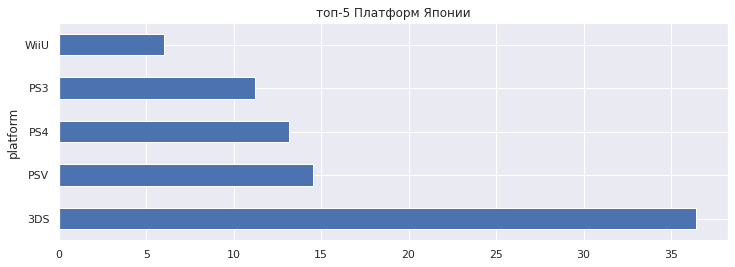

In [117]:
JP_top_platform = data_new.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head()
JP_top_platform.plot(kind = 'barh', title = 'топ-5 Платформ Японии')

<AxesSubplot:title={'center':'топ-5 жанров Японии'}, ylabel='genre'>

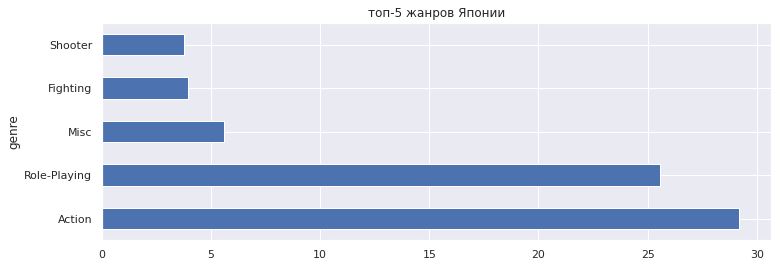

In [118]:
JP_top_genre = data_new.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head()
JP_top_genre.plot(kind = 'barh', title = 'топ-5 жанров Японии')

### Рейтинг

/tmp/ipykernel_31/489054752.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_new.groupby('rating_age')['na_sales', 'eu_sales', 'jp_sales'].sum().plot(kind = 'bar', title = 'продажи по возрастному рейтингу')


<AxesSubplot:title={'center':'продажи по возрастному рейтингу'}, xlabel='rating_age'>

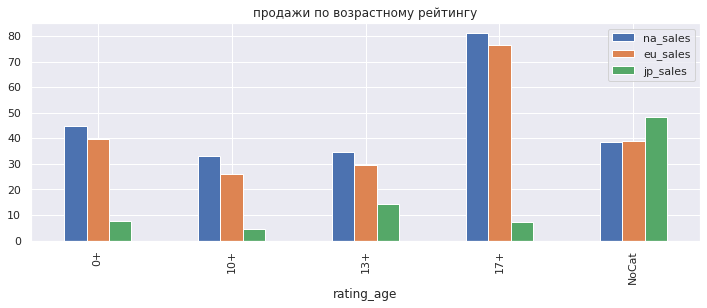

In [119]:
data_new.groupby('rating_age')['na_sales', 'eu_sales', 'jp_sales'].sum().plot(kind = 'bar', title = 'продажи по возрастному рейтингу')

**Выводы** 
- В Северной Америке пользователи предпочитают играть на традиционных стационарных платформах от PS и Xbox. Наиболее популярные жанры в порядке убывания: Экшн, Шутер, Спорт, РПГ. 
- В Европе аналогичная картина, но в топ-5 дополнительно входит ПК, а среди жанров добавляются гонки. 
- В Японии предпочитают портативные консоли от местных производителей. Среди жанров также на первом месте по популярности находится Экшн, но РПГ имеет близкие значения. Кроме этого, в топ-5 входит файтинг. 
- Игры с пометкой для взрослых 17+(содержат сцены насилия и секса) более чем в два раза превосходят все остальные в Европе и Северной Америке. В то время как в Японии они составляют небольшую долю рынка. Стоит однако обратить внимание, что большая часть проданных игр не имеет категории по ESRB, так как, вероятнее всего, оценивалась по внутренней системе рейтингов.


## Статистический анализ данных

Выше в исследовании была выдвинута гипотеза о том, что распределение рейтингов игр имеет схожую картину для одних и тех же игр на разных платформах. Проверим её в более широком смысле на сравнении двух пар выборок - по паре платформ и паре жанров. Для этого используем ttest для независимых выборок с разной дисперсией. Значение уровня значимости установим стандартное 0,05. 

### Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

H_0: Пользовательский рейтинг user_score платформы XOne = Пользовательский рейтинг user_score платформы PC`

H_a: Пользовательский рейтинг user_score платформы XOne ≠ Пользовательский рейтинг user_score платформы PC`

alpha = 0.05

In [120]:
data_user = data_new.loc[data_new['user_score'] != 0] #датасет с ненулевым рейтингом пользователей
Xone = data_user.loc[data_user['platform'] == 'XOne']['user_score'] # xbox one
PC = data_user.loc[data_user['platform'] == 'PC']['user_score'] # PC
results = st.ttest_ind(Xone, PC, equal_var = False)
# вызов метода для проверки гипотезы
alpha = 0.05
# значение уровня значимости
print(results.pvalue)
# вывод значения p-value на экран 
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
# условный оператор с выводом строки с ответом

0.11769775949373869
Не получилось отвергнуть нулевую гипотезу


### Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные"

H_0: Пользовательский рейтинг user_score жанра Action = Пользовательский рейтинг user_score жанра Sports`

H_a: Пользовательский рейтинг user_score жанра Action ≠ Пользовательский рейтинг user_score жанра Sports`

alpha = 0.05

In [121]:
action = data_user.loc[data_user['genre'] == 'Action']['user_score'] # action
sports = data_user.loc[data_user['genre'] == 'Sports']['user_score'] # sports
results = st.ttest_ind(action, sports , equal_var = False)
# вызов метода для проверки гипотезы
alpha = 0.05
# задайте значение уровня значимости
print(results.pvalue)
# вывод значения p-value на экран 
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
# условный оператор с выводом строки с ответом

5.865260771663542e-14
Отвергаем нулевую гипотезу


**Выводы** Первая гипотеза о равенстве рейтингов Xbox и ПК не отвергнута. Это ожидаемый результат, так как выше уже было показано, что рынок игр на Xbox и ПК во многом совпадает.
Второе предположение о том, что рейтинги разных жанров различны подтвердилось. Жанр Action является самым популярным и широко представленным во всех регионах на всех платформах, поэтому средний пользовательский рейтинг для него носит малоинформативный характер. В то время как спортивные симуляторы имеют свою нишу на рынке Северной Америки и Европы, не подвержены новаторским изменениям и год от года производят стабильный продукт

# Вывод

Была проанализирована выборка видеоигр, выпущенных с 1980 по 2016 годы, всего более 16000 наименований. После первичного анализа для прогнозирования рынка в 2017 году данные были обрезаны до периода 2014-2016 гг. В этом периоде наибольший вклад вносят консоли нового поколения - PS4, Xbox One, 3DS, а также ПК. Прогнозируемый срок жизни поколения консоли - 5-10 лет, соответственно все они сохранят актуальность и в будущем году, но стоит учитывать, что 3DS - самая старая из представленных и её популярность уже существенно упала. Наиболее распространённый жанр на всех платформах - action, большой ассортимент игр в этом жанре позволяет удерживать лидерство по продажам во всех регионах. Однако средняя доходность с каждого релиза имеет довольно средние значения.
Более выигрышной стратегией в Северной Америке и Европе является ставка на продажи шутеров с рейтингом 17+ - хотя их выпускается примерно в 4 раза меньше наименований, они приносят в целом гораздо более высокий доход. РПГ и спортивные симуляторы также занимают свою нишу на рынке и приносят стабильную прибыль чуть больше средних значений. Наиболее востребованная платформа среди пользователей этих регионов - PS4. В Северной Америке Xbox имеет сопоставимый уровень популярности с ней, а в Европе важной платформой остаётся ПК. 
Азиатские рынки имеют другую структуру. Здесь стоит сделать ставку на РПГ и Action, выпущенные специально для портативных консолей местного производства. Согласно имеющимся данным, игры 13+ имеют наибольшую долю на рынке этого региона, но эти выводы сложно верифицировать из-за отстуствия доступа к местным рейтинговым классификациям в имеющейся выборке.
При выборе релизов для наиболее активных рекламных кампаний на популярных европейских и североамериканских платформах стоит обращать внимание на рейтинги критиков, но с определённой долей осторожности, так как высокий рейтинг не является достаточным условием для успешности игры, однако чаще всего - необходимым. Коэффициент корреляции между ними составляет около 0.4. При этом нужно учитывать, что характерные рейтинги для каждого жанра на каждой платформе будут отличаться и нужно выбирать критерий отбора для каждого случая в отдельности. Азиатские рынки здесь снова отличаются и уровень корреляции для пользователей и критиков невысок и примерно одинаков(0,28). Бестселлерами здесь могут стать игры с любыми оценками.
Для дальнейшего анализа рекомендуется разделить данные по американско-европейским и азиатским рынкам из-за их существенно отличающихся структур. Для азиатских необходимо дополнительно привлечь данные с местными рейтинговыми системами, а также релизами, выходившими экслюзивно в этом регионе. В каждом регионе можно изучить влияние компании-издателя на уровень продаж, конверсию бюджета рекламных кампаний, способ продаж(магазины, цифровые игровые маркетплейсы, эксклюзивы платформ). Также стоит рассмотреть влияние стоимости и наличия скидок, состав издания(делюкс, наличие подписки на dlc) и т.д.
